# Introduction to deep hedging


The goal o this notebook is to train a neural network , that would generate using a series of asset prices a discrete hedging strategy the would minimise the squared value of the PNL of a trader at maturity , and then compare the results to simple delta hedging using the Black-Scholes model

In [565]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


# Parameters

In [566]:
# Black Scholes parameters

S0 = 100 # initial stock price
r = 0.04 # risk-free rate
sigma = 0.1 # volatility
T = 1 # time to maturity

# Heston model parameters
k = 0.1
theta = 0.04
sigma_v = 2
rho = -0.3

# Simulation parameters

N = 10
M = 100000


# Option parameters

K = 100 # strike price
payoff = lambda x: np.maximum(x - K, 0)*np.exp(-r*T) # payoff function

# Normalization
A = S0 * np.exp(r*T)

# Simulation of data

In [567]:
def Simulate_BS(S0, r, sigma, T, M, N , sigma_v = 0, k = 0, theta = 0, rho = 0, model = 'bs'):
    dt = T / N
    S = np.zeros((N+1, M))
    S[0] = S0
    if model == 'h':
        V = np.zeros((N+1, M))
        V[0] = sigma
    for t in range(1, N+1):
        if model == 'bs':
            Z = np.random.randn(M)
            S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        if model == 'h':
            Z = np.random.randn(2, M)
            V[t] = np.maximum(V[t-1] + k * (theta - V[t-1]) * dt + sigma_v * np.sqrt(V[t-1] * dt) * Z[1], 0)
            S[t] = S[t-1] * np.exp((r - 0.5 * V[t-1]) * dt + np.sqrt(V[t-1] * dt) * Z[0])
    return S

def discount(S , r = r , T = T):
    return S * np.exp(-r * np.linspace(0, T, N+1)[:, None])

def monte_carlo(sample, proba=0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba
    quantile = stats.norm.ppf(1 - alpha/2)  # function quantile
    ci_size = quantile * np.sqrt(var / sample.size)
    result = {
        'Mean': mean,
        'Variance': var,
        f'{proba*100}% Confidence Interval (Lower)': mean - ci_size,
        f'{proba*100}% Confidence Interval (Upper)': mean + ci_size
    }
    return result


S = Simulate_BS(S0, r, sigma, T, M, N)
S_discounted = discount(S)
payoffs = payoff(S[-1])

result = monte_carlo(payoffs)
print(result)

{'Mean': 6.1890461438998, 'Variance': 55.63323851379553, '95.0% Confidence Interval (Lower)': 6.142817062704886, '95.0% Confidence Interval (Upper)': 6.235275225094714}


In [568]:
def prepare_data(N,M,norm_factor =A , sigma_v = 0, k = 0, theta = 0, rho = 0, model = 'bs'):
    S = Simulate_BS(S0, r, sigma, T, M, N, sigma_v, k, theta, rho, model)
    S_discounted = discount(S)
    payoffs = payoff(S[-1])
    X =  torch.tensor(S_discounted, dtype=torch.float32).to(device).T / norm_factor
    Z = torch.tensor(payoffs[:, None], dtype=torch.float32).to(device) / norm_factor
    return X, Z

# Black-Scholes for comparison

In [569]:
def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1 = (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return spot * norm.cdf(d1) - strike * np.exp(-r * t) * norm.cdf(d2)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1 = (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))
    return norm.cdf(d1)

print(price_call_BS(S0, T))


6.178461553404809


Here we compute the pnl of a delta hedging strategy using a general hedging function


{'Mean': 0.14947294, 'Variance': 0.48731124, '95.0% Confidence Interval (Lower)': 0.13878383212867607, '95.0% Confidence Interval (Upper)': 0.16016204184707772}


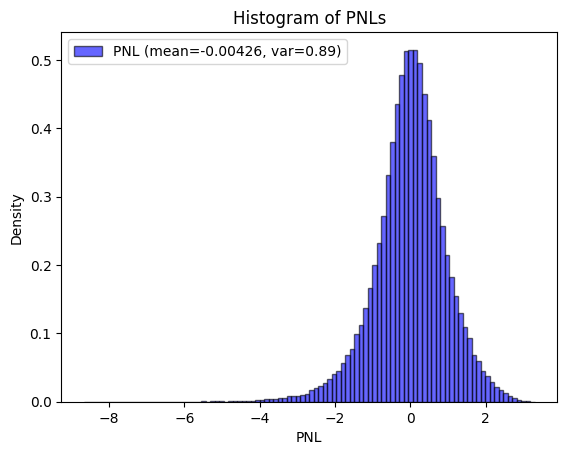

In [570]:
# Prepare data
X, Z = prepare_data(N, M)

# PNL Computations
def pnl(X, Z, hedging_fct):
    pnls = np.zeros(X[:, [0]].shape)
    deltas = []
    p0, d0 = hedging_fct(0, X[:, [0]])
    deltas.append(d0)
    pnls = p0 - d0 * X[:, [0]]
    for i in range(1, N):
        deltas.append(hedging_fct(i, X[:, [i]]))
        pnls = pnls - (deltas[i] - deltas[i-1]) * X[:, [i]]
    pnls = pnls + deltas[N-1] * X[:, [N]] - Z
    return pnls * np.exp(-r*T)

def delta_bs(i, x):
    if i == 0: 
        p0 = price_call_BS(S0, T) / A
        d0 = dprice_call_BS(x * A, T)
        return p0, torch.tensor(d0).to(device).float()
    else:
        return torch.tensor(dprice_call_BS(x * A * np.exp(r * i * T / N), T - i / N)).to(device).float()
def plot_pnl(pnls , label = 'PNL'):
    mean = np.mean(pnls)
    var = np.var(pnls, ddof=1)
    fig, ax = plt.subplots()
    ax.hist(pnls, bins=100, edgecolor='black', density=True, alpha=0.6, color='b', label=label)
    ax.set_xlabel('PNL')
    ax.set_ylabel('Density')
    ax.set_title('Histogram of PNLs')
    ax.legend([f'PNL (mean={mean:.5f}, var={var:.2f})'])
    plt.show()

# Calculate PNL using delta_bs
pnlbs = pnl(X, Z, delta_bs).detach().cpu().numpy().flatten() * A
print(monte_carlo(pnls))

# Plot PNL
plot_pnl(pnlbs)

### now we need to learn the optimal hedging strategy using a neural network

In [571]:
class simple_nn(nn.Module):
    "This class defines a simple neural network with input_size input neurons, hidden_sizes hidden layers and output_size output neurons"
    def __init__(self, input_size=1, hidden_sizes=[8,8], output_size=1 , batch_norm = True):
        super().__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))        
        self.dprice = nn.Sequential(*layers)

    def forward(self, x):
        return self.dprice(x)

class hedging_nn(nn.Module):
    "This class defines the hedging neural network it takes as input the time step and the input x delta at time t"
    def __init__(self, timesteps = N , input_size=1, hidden_sizes=[16,16], output_size=1, batch_norm = True):
        super().__init__()
        self.price_call_at_0 = nn.Parameter(torch.ones(1).to(device))
        self.dprice_call_at_0 = nn.Parameter(torch.ones(1).to(device))
        self.dprice = nn.ModuleList([simple_nn(input_size, hidden_sizes, output_size ,batch_norm =batch_norm ) for _ in range(1,timesteps)])

    def forward(self, i, x):
        if i == 0:
            return self.price_call_at_0, self.dprice_call_at_0
        else:
            return self.dprice[i-1](x)

In [572]:
def learn_hedging_function(X, Z, hedging_function, batch_size=1000, epochs=100, lr=0.1):
    """
    This function learns the hedging function using the hedging_function neural network
    
    X: torch.tensor of shape (M, N+1) containing the discounted stock prices
    Z: torch.tensor of shape (M, 1) containing the discounted payoff
    hedging_function: the hedging function to learn
    batch_size: the batch size
    epochs: the number of epochs
    
    Returns the learned hedging function and the losses
    """
    optimizer = torch.optim.Adam(hedging_function.parameters(), lr=lr)
    steps = M //(10* batch_size)
    
    losses = [] 
    
    with tqdm(total=epochs * steps) as pbar:
        for epoch in range(epochs*steps):
            idx = torch.randint(0, M, (batch_size,))
            optimizer.zero_grad()
            loss = torch.mean(pnl(X[idx], Z[idx], hedging_function)**2) / batch_size
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({'loss': loss.item()})
                
            losses.append(loss.item())
    return hedging_function , losses

hedging_function  = hedging_nn().to(device)
hedging_function , losses1 = learn_hedging_function(X, Z, hedging_function)


100%|██████████| 1000/1000 [00:18<00:00, 54.20it/s, loss=9.03e-8]


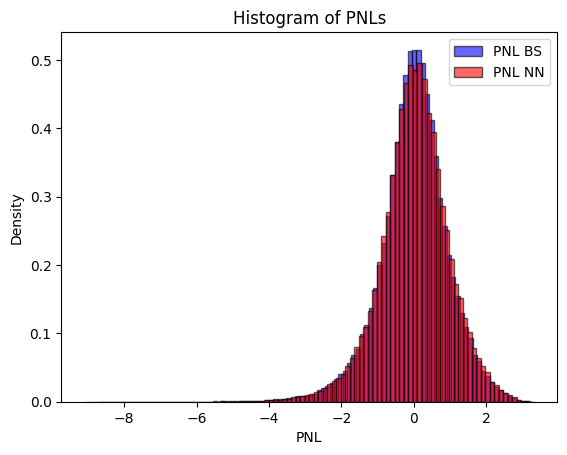

{'Mean': -0.0042621978, 'Variance': 0.88641864, '95.0% Confidence Interval (Lower)': -0.010097556111460607, '95.0% Confidence Interval (Upper)': 0.001573160586005132}
{'Mean': 0.016253356, 'Variance': 0.9073193, '95.0% Confidence Interval (Lower)': 0.010349603053275439, '95.0% Confidence Interval (Upper)': 0.022157108727749494}


In [573]:
def plot_compare_histogram(pnlbs, pnl1):
    """
    Plot the histogram of the PNLs obtained with the BS model and the NN model
    
    Args:
    pnlbs: np.array, PNLs obtained with the BS model
    pnl1: np.array, PNLs obtained with the NN model

    Returns:
    None
    """
    fig, ax = plt.subplots()
    ax.hist(pnlbs, bins=100, edgecolor='black', density=True, alpha=0.6, color='b', label='PNL BS')
    ax.hist(pnl1, bins=100, edgecolor='black', density=True, alpha=0.6, color='r', label='PNL NN')
    ax.set_xlabel('PNL')
    ax.set_ylabel('Density')
    ax.set_title('Histogram of PNLs')
    ax.legend()
    plt.show()

pnl1 = pnl(X, Z, hedging_function).detach().cpu().numpy().flatten() * A
plot_compare_histogram(pnlbs, pnl1)

print(monte_carlo(pnlbs))
print(monte_carlo(pnl1))


The approach above uses the same data on which te model is trained to evaluate the performance of the model. This is not a good idea in practice . instead of doing this we will genereate a new set of data on each epoch and use this data to train the model. And then see how it would comapre to black-scholes

In [574]:
def learn_hedging_function2(hedging_function, batch_size=10000, epochs=1000, lr=0.1):
    """
    This function learns the hedging function using the PNL loss

    Parameters:
    hedging_function: the hedging function to learn
    batch_size: the size of the batch
    epochs: the number of epochs

    Returns:
    hedging_function: the learned hedging function
    losses: the list of losses
    """
    optimizer = torch.optim.Adam(hedging_function.parameters(), lr=lr)    
    losses = [] 
    
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            X, Z = prepare_data(N , batch_size)
            optimizer.zero_grad()
            loss = torch.mean(pnl(X, Z, hedging_function)**2) / batch_size
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({'loss': loss.item()})                
            losses.append(loss.item())
    return hedging_function , losses

hedging_function  = hedging_nn().to(device)
hedging_function , losses2 = learn_hedging_function2(hedging_function)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:37<00:00, 26.69it/s, loss=8.56e-5]


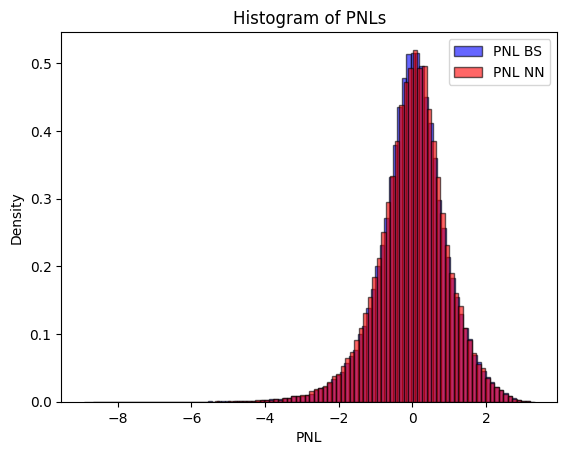

In [575]:
pnl2 = pnl(X, Z, hedging_function).detach().cpu().numpy().flatten() * A
plot_compare_histogram(pnlbs, pnl2)

## Further experiment : Using the Heston model model to generate the data

The Heston model is a stochastic volatility model that is widely used in the industry to model the volatility of an asset. We will use this model to generate the data and then train the model on this data and compare the results to the black-scholes model on this particular data

100%|██████████| 10000/10000 [04:51<00:00, 34.32it/s, loss=0.00225]


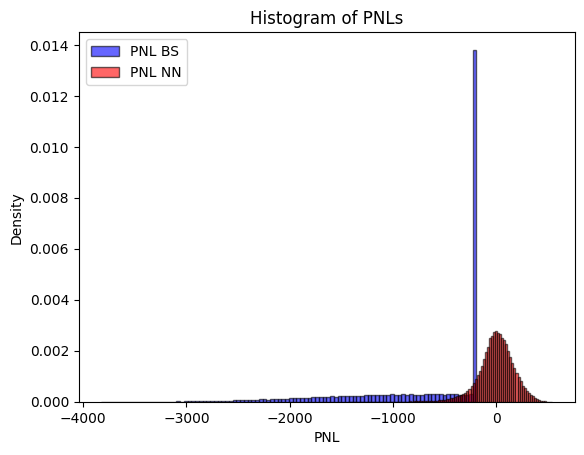

{'Mean': -690.24854, 'Variance': 459615.84, '95.0% Confidence Interval (Lower)': -694.4504339378774, '95.0% Confidence Interval (Upper)': -686.0466363746226}
{'Mean': -0.42435768, 'Variance': 28340.557, '95.0% Confidence Interval (Lower)': -1.4677611580717513, '95.0% Confidence Interval (Upper)': 0.6190457931387374}


In [579]:
S , Z = prepare_data(N, M, sigma_v, k, theta, rho, model = 'h')

hedging_function  = hedging_nn( N , hidden_sizes=[32,32,32], batch_norm = True).to(device)
hedging_function , losses3 = learn_hedging_function(S, Z, hedging_function , batch_size=1000, epochs=1000, lr=0.01)

pnl3 = pnl(S, Z, hedging_function).detach().cpu().numpy().flatten() * A
pnlbs = pnl(S, Z, delta_bs).detach().cpu().numpy().flatten() * A

plot_compare_histogram(pnlbs, pnl3)

print(monte_carlo(pnlbs))
print(monte_carlo(pnl3))

While it is normal to have such bad pnls when delta hedging the heston model ( which is normal since the volatility is stochastic and the delta hedging strategy is based on the assumption that the volatility is constant)

The neural network did perform better than the delta hedging strategy in this case. This is because the neural network is able to learn the stochastic nature of the volatility and adjust the hedging strategy accordingly .